In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone -b add-fewshot-urban --single-branch \
# https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub


rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 104 (delta 30), reused 95 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 424.22 KiB | 2.26 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
import os
import sys
from pathlib import Path
import torch
from tqdm import tqdm

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))



# ---- Project imports ----
from transformers import HubertModel

from src.datasets.urban_sound_8k import UrbanDataset
from src.methods.fewshot.benchmark import benchmark_fewshot
from src.evaluation.evaluate import evaluate_benchmark
from src.methods.fewshot.sampling import sample_task
from src.methods.fewshot.prototypical import compute_prototypes, classify

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Example : 1 experiment

In [4]:
root_dir = ""

dataset = UrbanDataset(root_dir)

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))


Using Colab cache for faster access to the 'urbansound8k' dataset.
Classes : ['fold1', 'fold10', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9']
Nombre total de fichiers : 8732


In [ ]:
X = []
y = []

for waveform, label in tqdm(dataset, desc="Loading dataset"):
    X.append(waveform)
    y.append(label)

X = torch.stack(X)
y = torch.tensor(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


Loading dataset: 100%|██████████| 8732/8732 [02:47<00:00, 52.07it/s]


X shape: torch.Size([8732, 16000])
y shape: torch.Size([8732])


In [14]:
X_support, y_support, X_query, y_query = sample_task(
    X,
    y,
    n_way=10,
    k_shot=1,
    n_query=20
)


In [8]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [15]:
prototypes, proto_labels = compute_prototypes(
    hubert, X_support, y_support, device=device
)

preds = classify(
    hubert, X_query, prototypes, proto_labels, device=device
)

acc = (preds.cpu() == y_query).float().mean()
print("Few-shot accuracy:", acc.item())


Few-shot accuracy: 0.10000000149011612


## Benchmark

In [16]:
results = {}
for k in [1,5,10]:
    results[k] = benchmark_fewshot(model=hubert, X=X, y=y, device=device, k_shot=k, n_tasks=10)


10-shot benchmark: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]



===== Few-shot evaluation summary =====

--- 1-shot ---
Accuracy : 0.2040 ± 0.0335
F1 macro : 0.2017


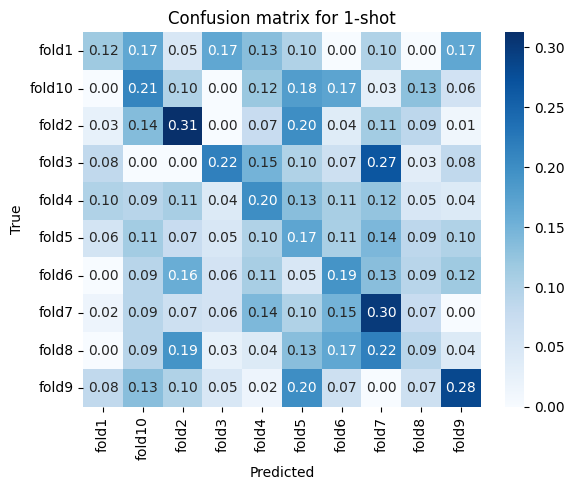


=== Evaluation metrics ===
accuracy    : 0.2040
f1_macro    : 0.2017
precision_macro: 0.2004
recall_macro: 0.2091


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


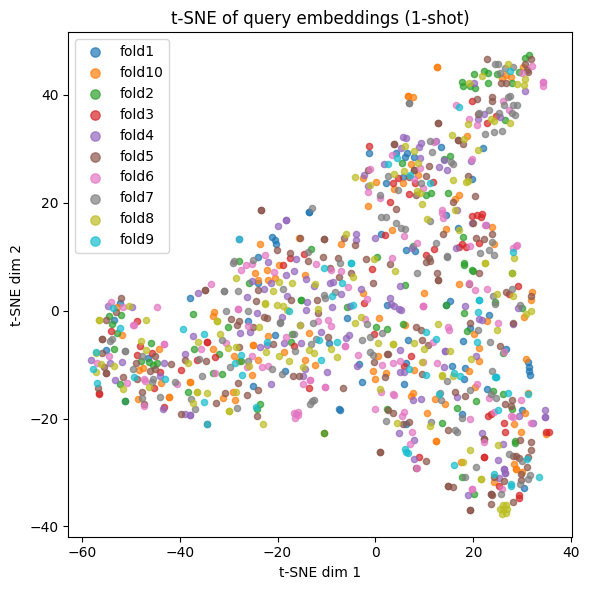


--- 5-shot ---
Accuracy : 0.2200 ± 0.0228
F1 macro : 0.2127


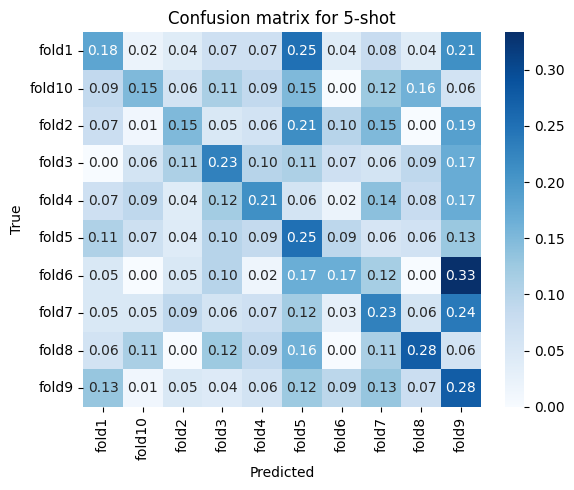


=== Evaluation metrics ===
accuracy    : 0.2200
f1_macro    : 0.2127
precision_macro: 0.2166
recall_macro: 0.2117


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


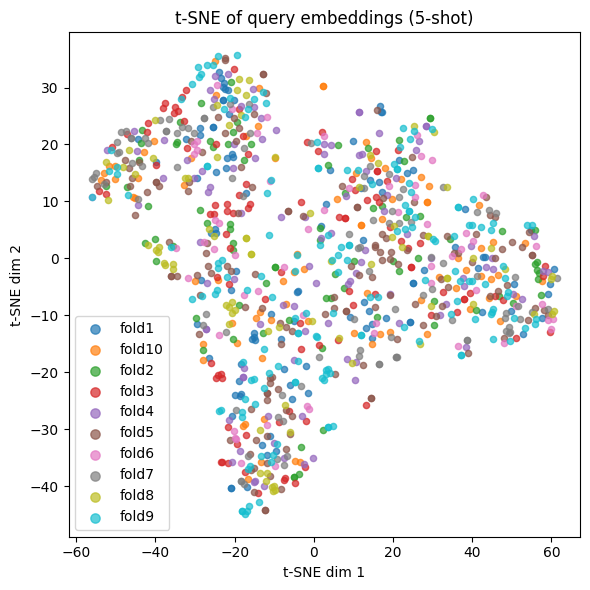


--- 10-shot ---
Accuracy : 0.2250 ± 0.0344
F1 macro : 0.2249


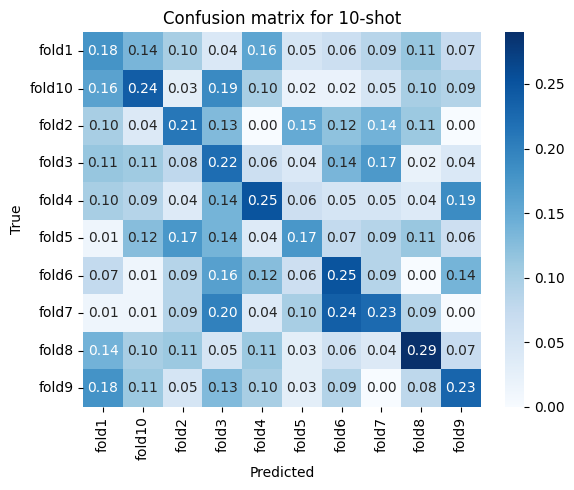


=== Evaluation metrics ===
accuracy    : 0.2250
f1_macro    : 0.2249
precision_macro: 0.2254
recall_macro: 0.2270


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


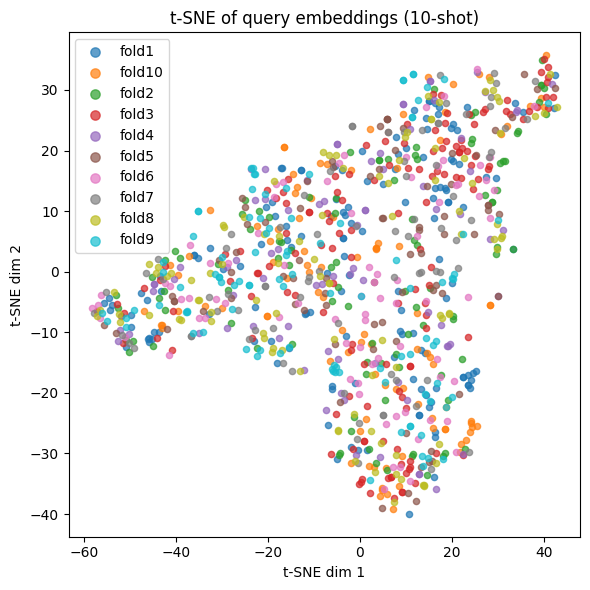

In [17]:
evaluate_benchmark(results, class_names=dataset.classes)